<a href="https://colab.research.google.com/github/sumasree10/OIBSIP/blob/main/Project_4_Proposal_Level_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset 1

In [ ]:
!pip install --quiet vaderSentiment gensim wordcloud pyLDAvis scikit-learn pandas numpy nltk matplotlib tqdm


In [ ]:
import os,zipfile
from google.colab import files
uploaded=files.upload()
for fn in uploaded.keys():
    if fn.lower().endswith(".zip"):
        with zipfile.ZipFile(fn,"r") as z: z.extractall("data_extracted")
        for root,_,fs in os.walk("data_extracted"):
            for f in fs:
                if f.lower().endswith(".csv"):
                    csv_path=os.path.join(root,f)
                    break
    else:
        csv_path=fn
print(csv_path)

Saving Twitter_Data.csv.zip to Twitter_Data.csv (2).zip
data_extracted/Twitter_Data.csv


In [ ]:
import pandas as pd
df=pd.read_csv(csv_path,encoding='utf-8',low_memory=False)
print(df.shape)
display(df.head())


(162980, 2)


,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [ ]:
import re,nltk,string
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("punkt_tab")
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
stop=set(stopwords.words("english"))
lem=WordNetLemmatizer()
def clean(t):
    if pd.isna(t): return ""
    t=str(t)
    t=re.sub(r"http\S+|@\w+|#"," ",t)
    t=re.sub(r"[^A-Za-z\s]"," ",t)
    t=t.lower()
    w=[lem.lemmatize(i) for i in nltk.word_tokenize(t) if i.isalpha() and i not in stop]
    return " ".join(w)
text_col=[c for c in df.columns if "text" in c.lower() or "tweet" in c.lower()]
if len(text_col)==0: text_col=[c for c in df.columns if df[c].dtype==object][0:1]
text_col=text_col[0]
df["clean_text"]=df[text_col].apply(clean)
df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,clean_text,category
0,modi promised minimum government maximum gover...,-1.0
1,talk nonsense continue drama vote modi,0.0
2,say vote modi welcome bjp told rahul main camp...,1.0
3,asking supporter prefix chowkidar name modi gr...,1.0
4,answer among powerful world leader today trump...,1.0


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
an=SentimentIntensityAnalyzer()
s=df["clean_text"].apply(lambda x: an.polarity_scores(x))
df["neg"]=s.apply(lambda x:x["neg"])
df["neu"]=s.apply(lambda x:x["neu"])
df["pos"]=s.apply(lambda x:x["pos"])
df["compound"]=s.apply(lambda x:x["compound"])
df.head()


,clean_text,category,neg,neu,pos,compound
0,modi promised minimum government maximum gover...,-1.0,0.095,0.682,0.223,0.5267
1,talk nonsense continue drama vote modi,0.0,0.351,0.649,0.000,-0.4019
2,say vote modi welcome bjp told rahul main camp...,1.0,0.000,0.651,0.349,0.7096
3,asking supporter prefix chowkidar name modi gr...,1.0,0.219,0.479,0.301,0.3400
4,answer among powerful world leader today trump...,1.0,0.000,0.763,0.237,0.4215


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
tf=TfidfVectorizer(max_features=20000,ngram_range=(1,2))
X=tf.fit_transform(df["clean_text"])
label=[c for c in df.columns if c.lower() in ("sentiment","label","target")]
if len(label)>0:
    y=df[label[0]].astype(str)
    Xtr,Xte,ytr,yte=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
    clf=LogisticRegression(max_iter=1000)
    clf.fit(Xtr,ytr)
    pred=clf.predict(Xte)
    print(classification_report(yte,pred))
else:
    km=KMeans(n_clusters=5,random_state=42)
    df["cluster"]=km.fit_predict(X)
    df.head()


In [ ]:
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.utils import simple_preprocess
texts=[simple_preprocess(t) for t in df["clean_text"]]
dictionary=Dictionary(texts)
dictionary.filter_extremes(no_below=5,no_above=0.5)
corpus=[dictionary.doc2bow(t) for t in texts]
lda=LdaModel(corpus=corpus,id2word=dictionary,num_topics=6,passes=5,random_state=42)
for i in range(6):
    print("Topic",i,lda.show_topic(i,10))


Topic 0 [('india', np.float32(0.05644802)), ('country', np.float32(0.015953423)), ('nation', np.float32(0.012741718)), ('government', np.float32(0.011872688)), ('govt', np.float32(0.011202207)), ('indian', np.float32(0.009416508)), ('narendra', np.float32(0.009357561)), ('namo', np.float32(0.009285019)), ('via', np.float32(0.008764306)), ('new', np.float32(0.008561007))]
Topic 1 [('year', np.float32(0.033845183)), ('job', np.float32(0.018266175)), ('congress', np.float32(0.017666852)), ('govt', np.float32(0.016659422)), ('money', np.float32(0.016415995)), ('crore', np.float32(0.012646898)), ('rahul', np.float32(0.012356947)), ('last', np.float32(0.011479485)), ('family', np.float32(0.010997766)), ('lakh', np.float32(0.010894494))]
Topic 2 [('election', np.float32(0.03047995)), ('bjp', np.float32(0.029640345)), ('seat', np.float32(0.019200265)), ('vote', np.float32(0.018569162)), ('win', np.float32(0.015619929)), ('rahul', np.float32(0.01291303)), ('narendra', np.float32(0.01263992)), (

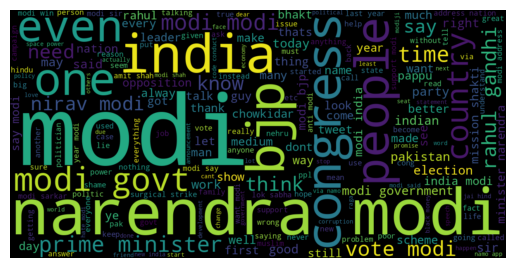

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wc=WordCloud(width=1200,height=600).generate(" ".join(df["clean_text"]))
plt.imshow(wc,interpolation="bilinear")
plt.axis("off")
plt.show()


In [ ]:
import pandas as pd,matplotlib.pyplot as plt
if any(c.lower() in ("date","created_at","timestamp") for c in df.columns):
    date_col=[c for c in df.columns if c.lower() in ("date","created_at","timestamp")][0]
    df["dt"]=pd.to_datetime(df[date_col],errors="coerce")
    ts=df.dropna(subset=["dt"]).set_index("dt").resample("D").size()
    plt.plot(ts.index,ts.values)
    plt.title("Daily Tweet Count")
    plt.show()


Dataset 2

In [ ]:
import kagglehub
mmmarchetti_play_store_dataset_path = kagglehub.dataset_download('mmmarchetti/play-store-dataset')

print('Data source import complete.')

100%|██████████| 1.94M/1.94M [00:00<00:00, 86.9MB/s]

Extracting files...
Data source import complete.


In [ ]:
import pandas as pd
import os

# Construct the correct file path using the downloaded directory
apps_with_duplicates = pd.read_csv(os.path.join(mmmarchetti_play_store_dataset_path, 'apps.csv'))


apps = apps_with_duplicates.drop_duplicates()


print('Total number of apps in the dataset = ', apps['App'].count())


n=5
apps.sample(n)

Total number of apps in the dataset =  9659


,Unnamed: 0,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
8498,9634,HTC Sense Input - EN,TOOLS,4.3,24175,8.5M,"5,000,000+",Free,0,Everyone,Tools,"October 30, 2015",1.0.612931,5.0 and up
8346,9471,Luxury Car Simulator,FAMILY,3.9,35989,46M,"1,000,000+",Free,0,Everyone,Simulation,"August 7, 2015",2.3,2.3.3 and up
5774,6805,Vip视频免费看-BT磁力搜索,TOOLS,NaN,20,7.9M,"1,000+",Free,0,Everyone,Tools,"June 8, 2018",1.2,4.0 and up
8643,9786,ES Task Manager (Task Killer ),BUSINESS,4.3,171771,3.2M,"10,000,000+",Free,0,Everyone,Business,"January 15, 2018",2.0.6.4,2.1 and up
4704,5686,Predator Calls for Hunting AU,SPORTS,4.4,27,78M,"10,000+",Free,0,Everyone,Sports,"August 3, 2016",1.0,4.0.3 and up


In [ ]:
chars_to_remove = ['+', ',', 'M', '$']
cols_to_clean = ['Installs', 'Size', 'Price']


for col in cols_to_clean:

    for char in chars_to_remove:
        apps[col] = apps[col].str.replace(char, '')
    apps[col] = pd.to_numeric(apps[col])

In [ ]:
import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.graph_objs as go

num_categories = len(set(apps['Category']))
print('Number of categories = ', num_categories)

num_apps_in_category = apps['Category'].value_counts().sort_values(ascending=False)

data = [go.Bar(
        x = num_apps_in_category.index,
        y = num_apps_in_category.values,
)]

plotly.offline.iplot(data)

Number of categories =  33


In [ ]:
avg_app_rating = apps['Rating'].mean()
print('Average app rating = ', avg_app_rating)

data = [go.Histogram(
        x = apps['Rating'],
        xbins = {'start': 1, 'size': 0.1, 'end' : 5}
)]

layout = {'shapes': [{
              'type' :'line',
              'x0': avg_app_rating,
              'y0': 0,
              'x1': avg_app_rating,
              'y1': 1000,
              'line': { 'dash': 'dashdot'}
          }]
          }

plotly.offline.iplot({'data': data, 'layout': layout})

Average app rating =  4.173243045387994


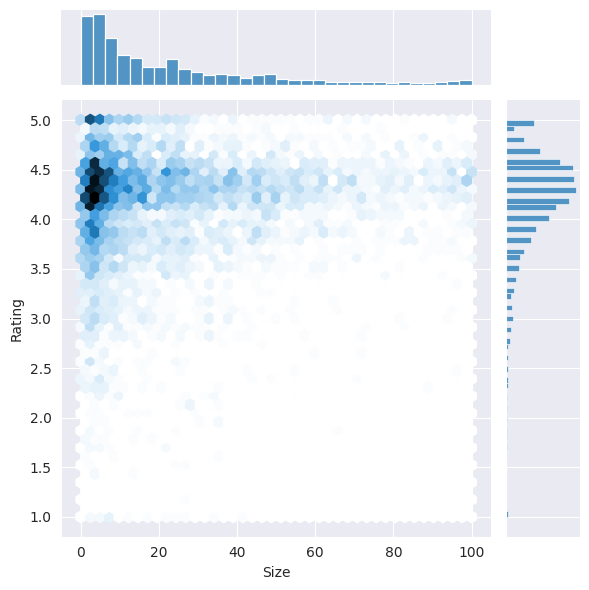

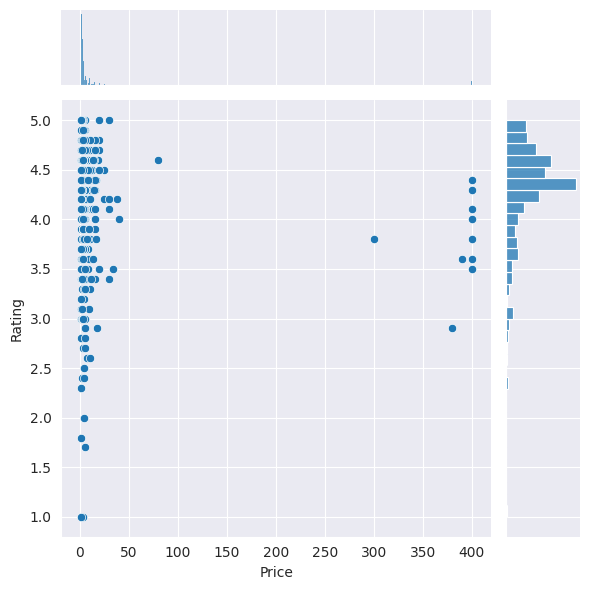

In [ ]:
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
import warnings
warnings.filterwarnings("ignore")

large_categories = apps.groupby('Category').filter(lambda x: len(x) >= 250).reset_index()

plt1 = sns.jointplot(x = 'Size', y = 'Rating', data = large_categories, kind = 'hex')

paid_apps = apps[apps['Type'] == 'Paid']

plt2 = sns.jointplot(x = 'Price', y = 'Rating', data = paid_apps)

,Category,App,Price
3327,FAMILY,most expensive app (H),399.99
3465,LIFESTYLE,💎 I'm rich,399.99
3469,LIFESTYLE,I'm Rich - Trump Edition,400.00
4396,LIFESTYLE,I am rich,399.99
4398,FAMILY,I am Rich Plus,399.99
4399,LIFESTYLE,I am rich VIP,299.99
4400,FINANCE,I Am Rich Premium,399.99
4401,LIFESTYLE,I am extremely Rich,379.99
4402,FINANCE,I am Rich!,399.99
4403,FINANCE,I am rich(premium),399.99


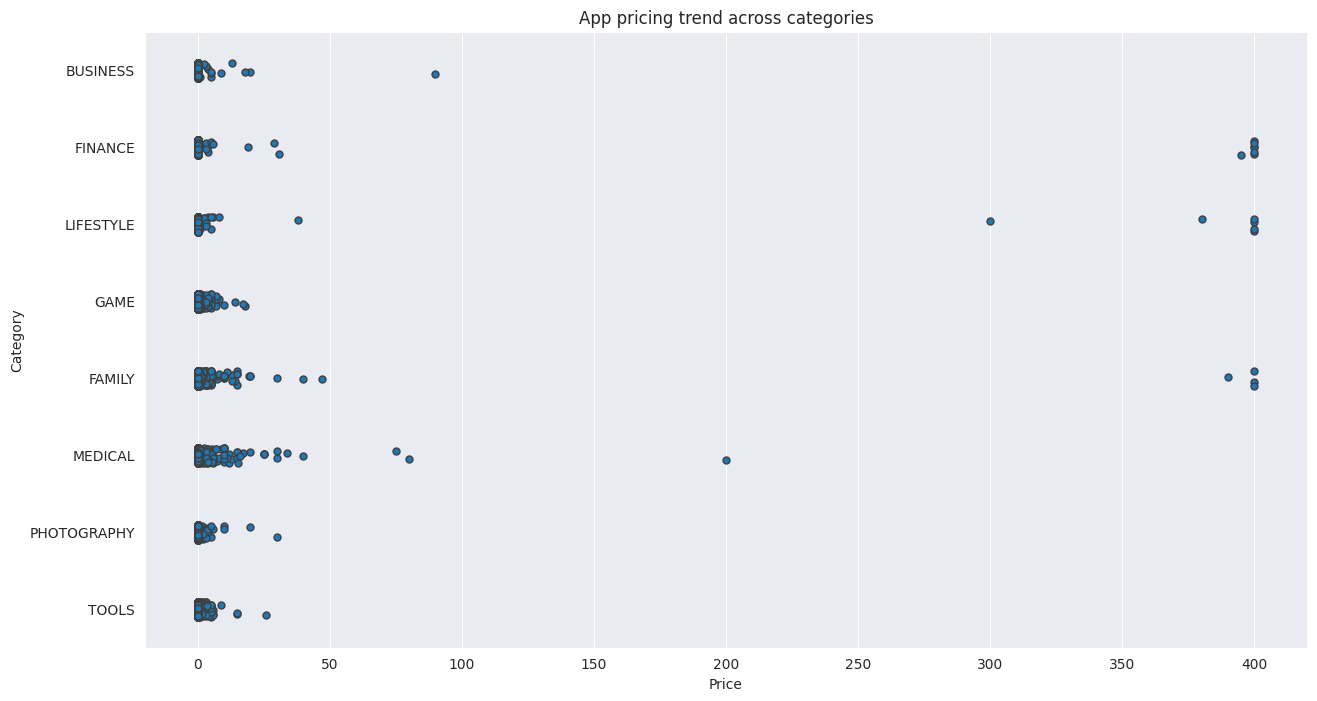

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)

popular_app_cats = apps[apps.Category.isin(['GAME', 'FAMILY', 'PHOTOGRAPHY',
                                            'MEDICAL', 'TOOLS', 'FINANCE',
                                            'LIFESTYLE','BUSINESS'])]

ax = sns.stripplot(x='Price', y='Category', data=popular_app_cats,
                   jitter=True, linewidth=1)
ax.set_title('App pricing trend across categories')

apps_above_200 = popular_app_cats[['Category', 'App', 'Price']][popular_app_cats['Price'] > 200]
apps_above_200

Text(0.5, 1.0, 'App pricing trend across categories after filtering for junk apps')

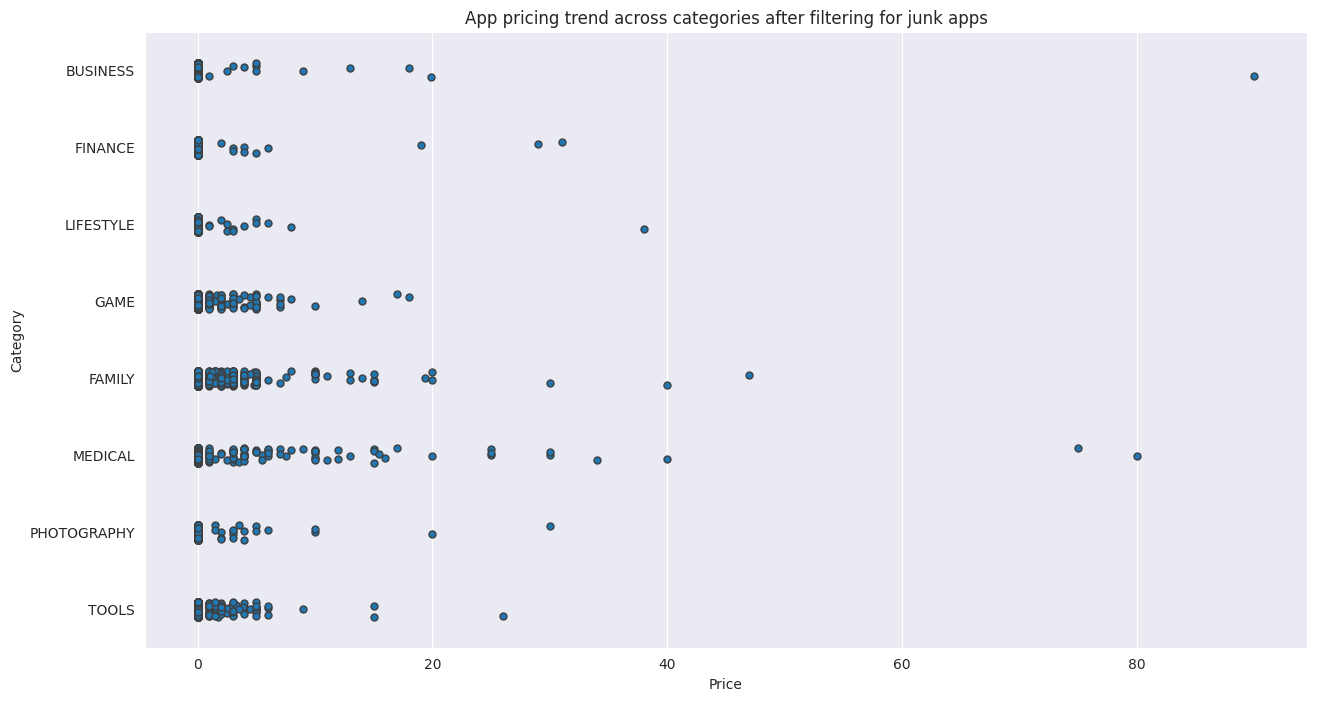

In [ ]:
apps_under_100 = popular_app_cats[popular_app_cats['Price'] < 100]

fig, ax = plt.subplots()
fig.set_size_inches(15, 8)

ax = sns.stripplot(x='Price', y='Category', data=apps_under_100,
                   jitter=True, linewidth=1)
ax.set_title('App pricing trend across categories after filtering for junk apps')

In [ ]:
trace0 = go.Box(
    y=apps['Installs'][apps['Type'] == 'Paid'],
    name = 'Paid'
)

trace1 = go.Box(
    y=apps['Installs'][apps['Type'] == 'Free'],
    name = 'Free'
)

layout = go.Layout(
    title = "Number of downloads of paid apps vs. free apps",
    yaxis = dict(
        type = 'log',
        autorange = True
    )
)

data = [trace0, trace1]
plotly.offline.iplot({'data': data, 'layout': layout})

Text(0.5, 1.0, 'Sentiment Polarity Distribution')

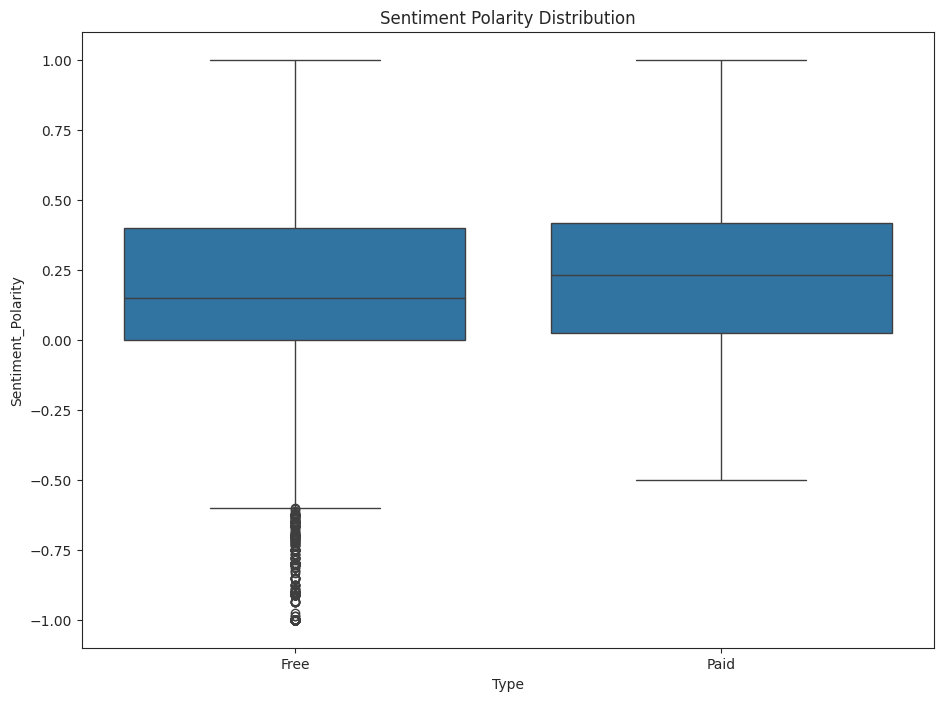

In [ ]:
reviews_df = pd.read_csv(mmmarchetti_play_store_dataset_path + '/user_reviews.csv')

merged_df = pd.merge(apps, reviews_df, on='App', how = "inner")

merged_df = merged_df.dropna(subset=['Sentiment', 'Translated_Review'])

sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11, 8)

ax = sns.boxplot(x = 'Type', y = 'Sentiment_Polarity', data = merged_df)
ax.set_title('Sentiment Polarity Distribution')